In [5]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective,helpers # Difference a. We are using ComplexDynamicsProblem
import matplotlib.pyplot as plt
import json
import os
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from tqdm import tqdm
import scipy 
import pickle as pckl

In [6]:
import sys
print(sys.path[1])

/usr/lib/python311.zip


In [7]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


# List instances

In [8]:
path = f'../data/instances/'
for item in os.listdir(path):
    if item[-5:] == '.pckl':
        with open(os.path.join(path, item),'rb') as f:
            print(f"---------- System {item[0]} ------------")
            print(pckl.load(f)['about'])

---------- System 2 ------------
np.pi*1/math.sqrt(2)(X+Z)
---------- System 6 ------------
np.pi/2*|000><111|+|111><000|
---------- System 3 ------------
PT Symmetric from |0>
---------- System 4 ------------
maximally entangled qubit
---------- System 5 ------------
|00><11|+|00><11|
---------- System 8 ------------
sigma_y
---------- System 1 ------------
0.5PI * SY
---------- System 7 ------------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)


# Analyze

In [9]:
def load_data(pruned = True, raw = False,topology='5.4',system=1):
    if pruned:
        path = f'../data/results/pruned/{system}/'

    else:
        path = f'../data/results/notpruned/{system}/'
    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            s = s.to_pandas_dataframe()

            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [10]:
topology='5.4'
dfs_all = load_data(pruned = True,topology=topology,system=4)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram

In [11]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100

dfs_grouped_rounded 

/tmp/ipykernel_8821/4200412015.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.12 0.16 0.06 0.04 0.48 0.08 0.12 0.08 0.14 0.12 0.06 0.04 0.66 0.16
 0.22 0.56 0.04 0.14 0.04 1.02 0.04 0.12 0.24 0.38 0.02 0.02 0.02 0.04
 0.52 0.16 0.6  0.18 0.32 0.1  1.58 0.08 0.54 0.04 1.04 0.26 0.6  0.1
 1.24 0.22 0.28 0.02 0.38 0.4  0.76 0.02 0.06 0.06 0.02 0.06 0.08 0.02
 0.26 0.24 0.86 0.04 0.58 1.04 0.34 0.82 0.24 2.26 0.22 0.84 0.08 1.5
 0.76 1.06 0.24 1.26 0.44 0.54 0.24 0.4  0.64 1.06 0.12 0.04 0.12 0.1
 0.12 0.16 0.02 0.02 0.04 0.06 0.02 0.16 0.14 0.56 0.04 0.44 0.14 0.8
 0.08 0.6  0.12 1.38 0.52 1.2  0.3  1.76 0.74 1.1  0.3  1.26 0.94 1.44
 0.54 1.22 0.86 0.9  0.2  0.46 0.52 0.68 0.24 0.06 0.14 0.3  0.14 0.08
 0.04 0.02 0.02 0.1  0.04 0.2  0.04 0.24 0.02 0.32 0.1  0.36 0.2  0.94
 0.32 0.66 0.22 1.08 0.68 1.06 0.34 1.18 0.82 0.92 0.38 0.82 0.68 1.24
 0.38 0.6  0.02 0.52 0.84 0.48 0.34 0.4  0.66 0.24 0.18 0

systemid  precision  timepoints  energy
5.4       2          2           1          0.38
                                 2          2.72
                                 3          7.28
                                 4         13.90
                                 5         19.10
                                 6         19.84
                                 7         15.54
                                 8         10.70
                                 9          5.22
                                 10         2.48
                                 11         1.38
                                 12         0.78
                                 13         0.42
                                 14         0.08
                                 15         0.06
                                 16         0.02
                                 17         0.02
                                 18         0.06
                                 20         0.02
Name: num_occurrences, dtype:

defaultdict(<class 'list'>, {2: [2]})
prec 2 timepoints 2
   energy  num_occurrences
0       1             0.38
1       2             2.72
2       3             7.28
3       4            13.90
4       5            19.10


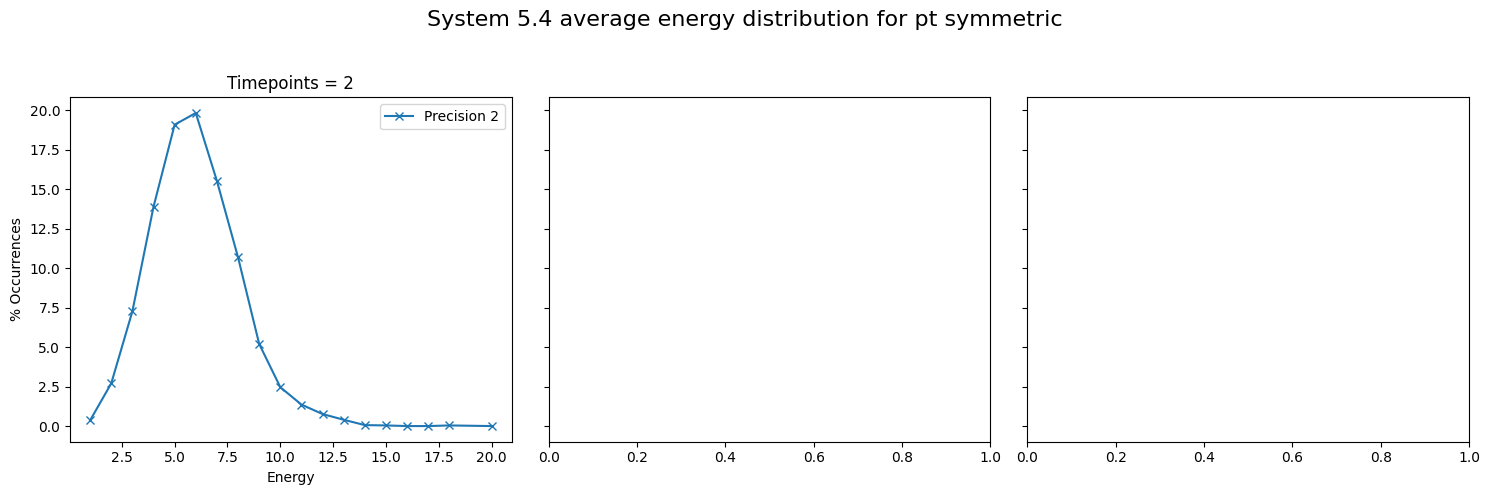

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(f"System {topology} average energy distribution for pt symmetric", fontsize=16)
markers = ['x','o','v']
prec_time_pairs = get_precision_timepoints_pairs(dfs_all)
timepoint_dict = defaultdict(list)
for timepoint_par in prec_time_pairs:
    timepoint_dict[timepoint_par[1]].append(timepoint_par[0])

print(timepoint_dict)
timepoints = sorted(timepoint_dict.keys())
for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    for p in sorted(timepoint_dict[timepoint]):
        df = dfs_grouped_rounded[topology, p, timepoint].reset_index()
        print(f"prec {p} timepoints {timepoint}")
        print(df.head(5))
        ax.plot(df['energy'], df['num_occurrences'], label=f"Precision {p}", marker=markers[p-2])

    ax.set_xlabel('Energy')
    ax.set_title(f"Timepoints = {timepoint}")
    #ax.set_xlim(0, 200)
    if i == 0:
        ax.set_ylabel('% Occurrences')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig('../plots/system54_energy_distribution.pdf')
plt.show()

# Interpret results

-------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)
---------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
-------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)
---------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
-------
np.pi*helpers.generate_pt_symmetric_real_eig(0.5)
---------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------
---------
array([[-1.+0.00000000e+00j,  0.+6.57201340e-16j],
       [ 0.+7.77156117e-16j, -1.+0.00000000e+00j]])
------


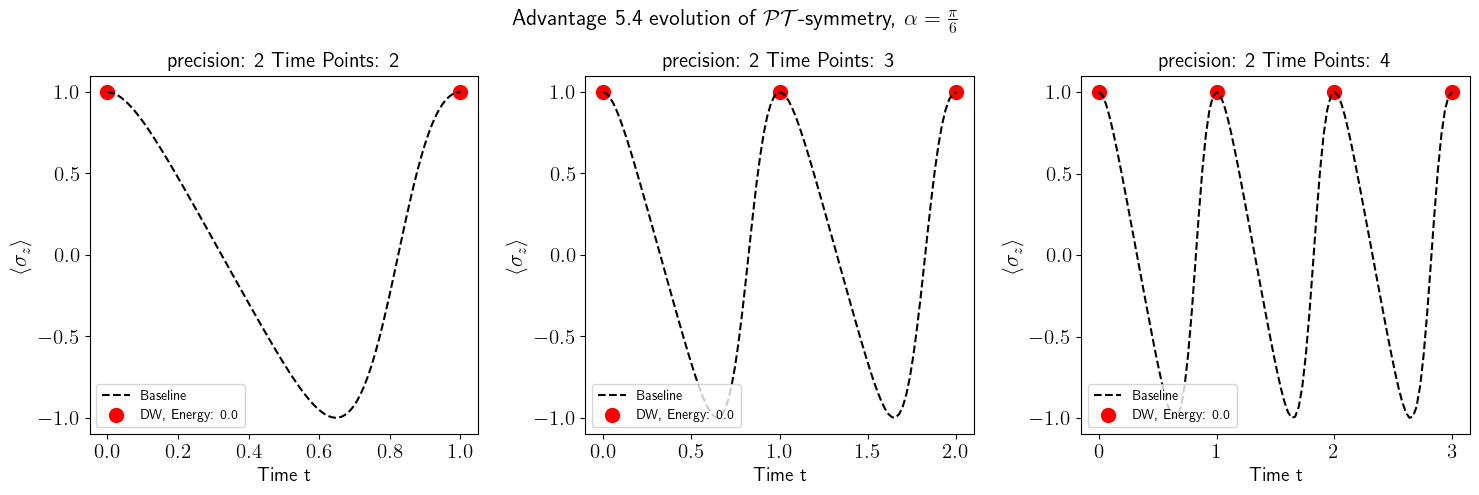

In [47]:
import qutip as qp

system = 7

plt.rcParams['text.usetex'] = True
dfs_data_raw = load_data(raw=True,topology=topology,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
SZ = np.array([[1, 0], [0, -1]])


plot_rows =  1
plot_columns = 3
# Create a single axis for the plot
fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(5*plot_columns, 5*plot_rows), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system',
    7: '$\mathcal{P}\mathcal{T}$-symmetry, $\\alpha=\\frac{\\pi}{6}$'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    instance = helpers.get_instance(system)
    H = instance['H']
    PSI0 = instance['psi0']


    #baseline 
    dim = int(math.log(len(H),2))




    psi_0 = qp.tensor([qp.basis(2, 0)]*dim)


    #psi_0 = PSI0
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(qp.Qobj(H), psi_0, times, e_ops=[qp.sigmaz()]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="Baseline")


    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)
        dw_expect = [(state.conj() @ SZ @ state).real for state in vec]

        ax.scatter(problem.times, dw_expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"DW, Energy: {abs(round(energies[j],4))}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=14)
    ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}",fontsize=15)


    ax.legend(loc='lower left')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

fig.suptitle(f"Advantage {topology} " +rf"evolution of {system_latex_dict[system]} ",fontsize=16)
plt.tight_layout()
plt.savefig(f'../plots/solver_{topology}_dynamic_{system}.pdf')
plt.show()



-------
|00><11|+|00><11|
---------
---------
array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j]])
------
-------
|00><11|+|00><11|
---------
---------
array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j]])
------
---------
array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j]])
------
-------
|00><11|+|00><11|
---------
---------
array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j]])
------
---------
array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.-1.j, 0.+0.j, 0.+0.j,

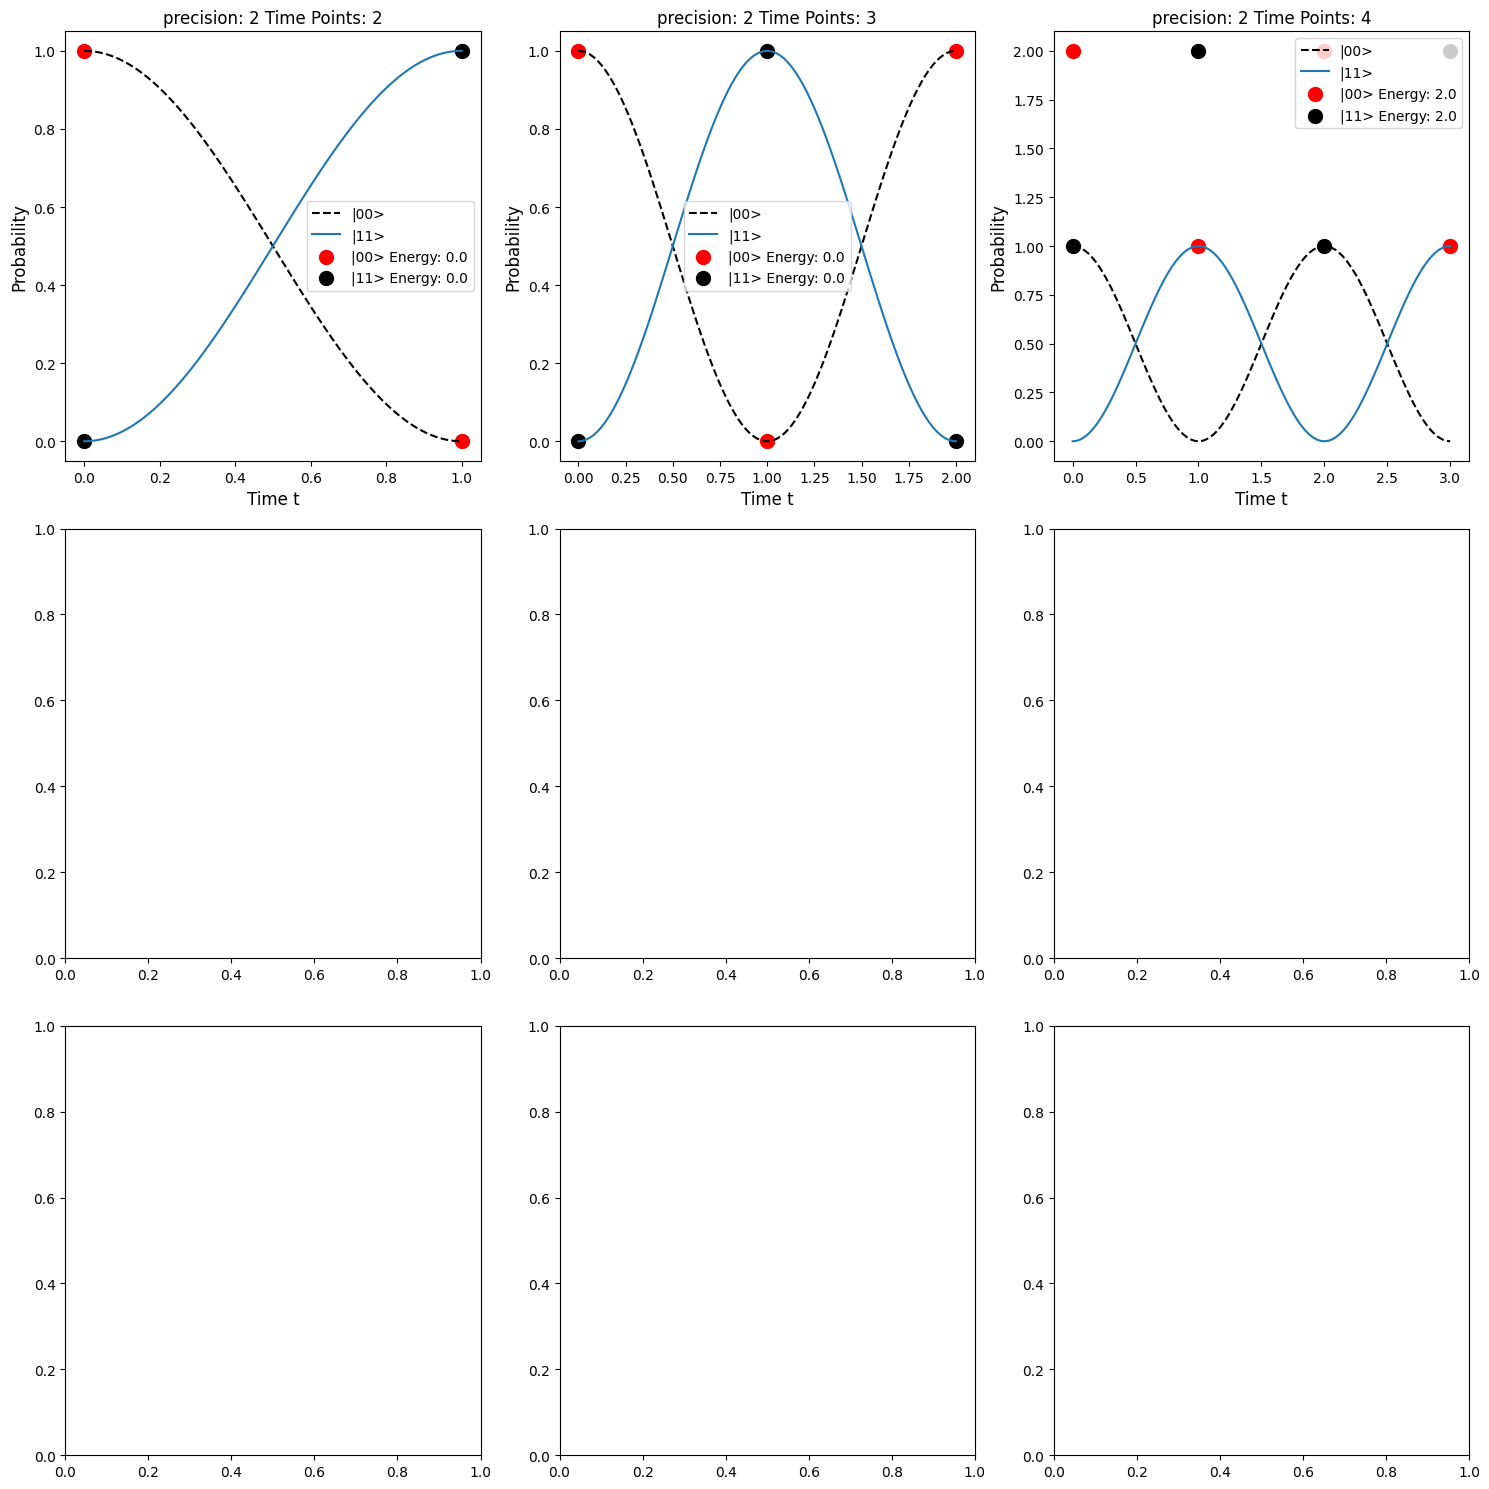

In [ ]:
import qutip as qp

system = 5

dfs_data_raw = load_data(raw=True,topology=topology,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    instance = helpers.get_instance(system)
    H = instance['H']

    #baseline 
    dim = int(math.log(len(H),2))

    # Projectors on |0..0⟩ and |1..1⟩
    P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.tensor([qp.basis(2, 0)]*dim)


    #psi_0 = PSI0
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00, P_11]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
#fig.suptitle(f"Advantage {topology} " +rf"evolution of {system_latex_dict[system]} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



In [10]:
qp.basis(3,0)

Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]]

In [11]:
# Define the GHZ Hamiltonian: π (|000⟩⟨111| + |111⟩⟨000|)


H = np.zeros((4, 4))
H[0, 3] = 1
H[3, 0] = 1
scipy.linalg.expm(1.0j*H*np.pi/2)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [12]:
import numpy as np
import qutip as qp
import matplotlib.pyplot as plt

# Define the GHZ Hamiltonian: π (|000⟩⟨111| + |111⟩⟨000|)
H = np.zeros((8, 8))
H[0, 7] = np.pi
H[7, 0] = np.pi

# Wrap as Qobj with proper qubit structure: 3 qubits = [2, 2, 2]
H = qp.Qobj(H, dims=[[2, 2, 2], [2, 2, 2]])

# Initial state |000⟩ = |0>⊗|0>⊗|0>
psi0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 0), qp.basis(2, 0))

# Projectors on |000⟩ and |111⟩
P_000 = qp.ket2dm(qp.tensor(qp.basis(2, 0), qp.basis(2, 0)))
P_111 = qp.ket2dm(qp.tensor(qp.basis(2, 1), qp.basis(2, 1)))

# Time grid
times = np.linspace(0, 1, 200)

# Solve the Schrödinger equation
result = qp.mesolve(H, psi0, times, e_ops=[P_000, P_111])

# Plot probabilities over time
plt.plot(times, result.expect[0], label='|000⟩')
plt.plot(times, result.expect[1], label='|111⟩')
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("GHZ-like oscillation: |000⟩ ↔ |111⟩")
plt.legend()
plt.grid(True)
plt.show()


ValueError: incompatible dimensions [2, 2] and [2, 2, 2]

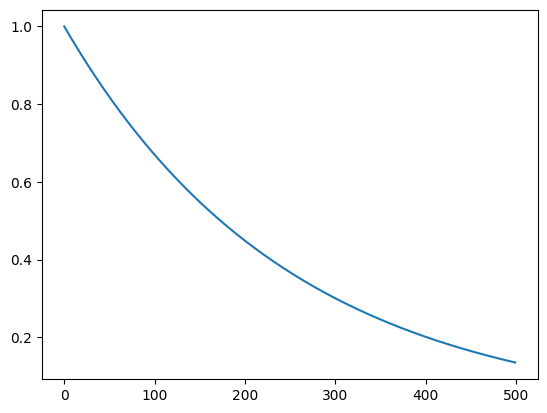

In [ ]:
import numpy as np
import qutip as qp

# État de Bell initial (intriqué)
psi0 = qp.bell_state() 

# Hamiltonien trivial (juste pour la forme)
H = qp.tensor(qp.qeye(2), qp.qeye(2))

# Opérateurs de collapse : relaxation du 1er et 2e qubit
gamma = 0.1
c_ops = [
    np.sqrt(gamma) * qp.tensor(qp.destroy(2), qp.qeye(2)),
    np.sqrt(gamma) * qp.tensor(qp.qeye(2), qp.destroy(2))
]

# Résolution
times = np.linspace(0, 10, 500)
result = qp.mesolve(H, psi0, times,c_ops=c_ops)

# Calcul du degré d’intrication (e.g. concurrence)
concurrences = [qp.concurrence(rho) for rho in result.states]
plt.plot(concurrences)

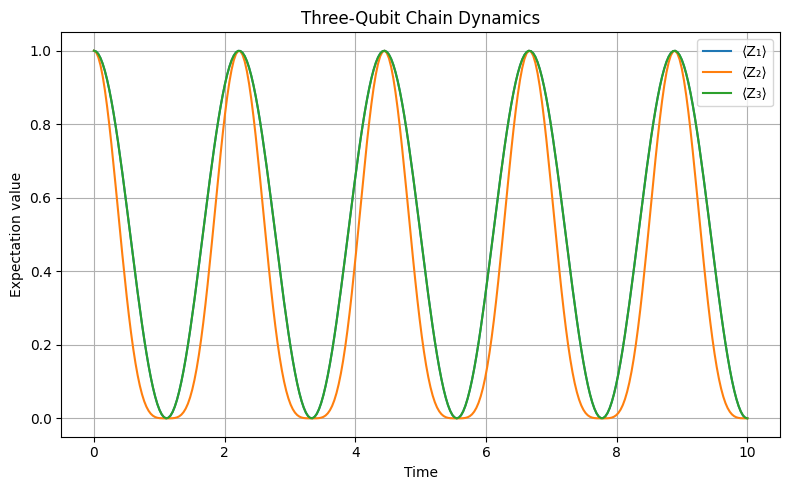

In [ ]:
import numpy as np
import qutip as qp
import matplotlib.pyplot as plt

# Pauli operators
X = qp.sigmax()
Z = qp.sigmaz()
I = qp.qeye(2)

# Coupling constants
J = 1  # XX interaction strength
K = 1  # ZZ interaction strength

# Build 3-qubit Hamiltonian
H = (
    J * (qp.tensor(X, X, I) + qp.tensor(I, X, X)) +
    K * (qp.tensor(Z, Z, I) + qp.tensor(I, Z, Z))
)

# Initial state: |000>
psi0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 0), qp.basis(2, 0))

# Time evolution
times = np.linspace(0, 10, 300)
result = qp.mesolve(H, psi0, times, [], e_ops=[
    qp.tensor(Z, I, I),   # <Z1>
    qp.tensor(I, Z, I),   # <Z2>
    qp.tensor(I, I, Z)    # <Z3>
])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(times, result.expect[0], label="⟨Z₁⟩")
plt.plot(times, result.expect[1], label="⟨Z₂⟩")
plt.plot(times, result.expect[2], label="⟨Z₃⟩")
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.title("Three-Qubit Chain Dynamics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import scipy.linalg


pt = helpers.generate_pt_symmetric_real_eig(0.5)
scipy.linalg.eig(pt)

(array([ 1.+0.00000000e+00j, -1.-3.46944695e-17j]),
 array([[ 0.63245553+0.31622777j, -0.63245553+0.31622777j],
        [ 0.70710678+0.j        ,  0.70710678+0.j        ]]))